## In a regression problem, we aim to predict the output of a continuous value, like a price or a probability.
### This notebook uses the classic Auto MPG Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

In [101]:
from __future__ import absolute_import, division, print_function

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.13.1


In [102]:
# Get the data
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path


'/Users/gmontes/.keras/datasets/auto-mpg.data'

In [103]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin'] 
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.head(10)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
5,15.0,8,429.0,198.0,4341.0,10.0,70,1
6,14.0,8,454.0,220.0,4354.0,9.0,70,1
7,14.0,8,440.0,215.0,4312.0,8.5,70,1
8,14.0,8,455.0,225.0,4425.0,10.0,70,1
9,15.0,8,390.0,190.0,3850.0,8.5,70,1


In [104]:
# Clean the data.
print(dataset.isna().sum())
dataset = dataset.dropna()

# The "Origin" column is really categorical, not numeric. So convert that to a one-hot.
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [105]:
# Split the data into train and test.
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

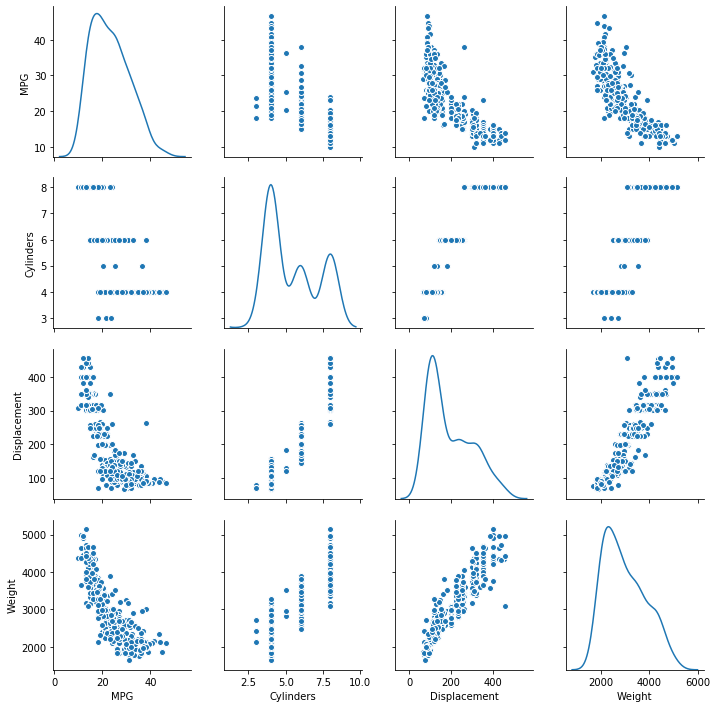

In [106]:
# Inspect the data.
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [107]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [108]:
# Split features from labels.
# Separate the target value, or "label", from the features. 
# This label is the value that you will train the model to predict.
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [109]:
# Normalize the data.
# Look again at the train_stats block above and note how different the ranges of each feature are.
# It is good practice to normalize features that use different scales and ranges. 
# Although the model might converge without feature normalization, 
# it makes training more difficult, 
# and it makes the resulting model dependent on the choice of units used in the input.
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


In [110]:
# Build the model
# We'll use a Sequential model with two densely connected hidden layers, 
# and an output layer that returns a single, continuous value. 
# The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

model = build_model()

In [111]:
# Inspect the model.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [112]:
# Try out the model.
# Take a batch of 10 examples from the training data and call model.predict on it.
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.04543892],
       [-0.0160948 ],
       [ 0.28141984],
       [ 0.11706504],
       [-0.17524129],
       [-0.01768734],
       [-0.16622393],
       [-0.23908214],
       [-0.00136634],
       [-0.16167992]], dtype=float32)

In [113]:
# Train the model.
# Train the model for 1000 epochs, and record the training and validation accuracy in the history object.

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [114]:
# Visualize the model's training progress using the stats stored in the history object.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.465383,0.994285,2.465383,11.828046,2.469094,11.828046,995
996,2.491103,1.022296,2.491103,10.797015,2.395394,10.797014,996
997,2.469330,1.027642,2.469330,11.051478,2.513645,11.051478,997
998,2.512228,1.016053,2.512228,10.706269,2.404786,10.706269,998
999,2.389331,0.989683,2.389331,10.666890,2.473174,10.666890,999


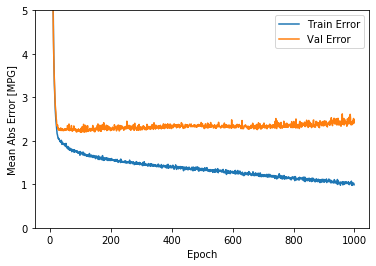

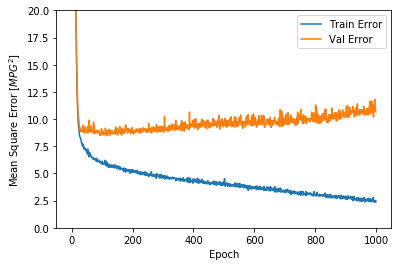

In [115]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


...........................................................................................

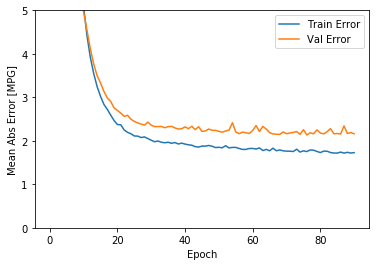

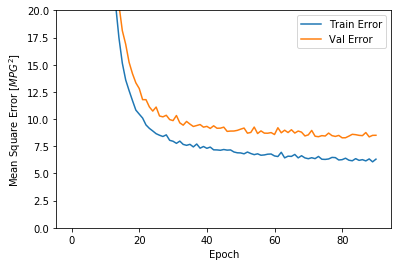

In [116]:
# Let's update the model.fit call to automatically stop training when the validation score doesn't improve.
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [117]:
# Let's see how well the model generalizes by using the test set, which we did not use when training the model.
# This tells us how well we can expect the model to predict when we use it in the real world.
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.89 MPG


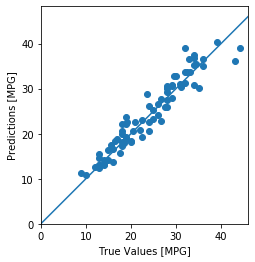

In [118]:
# Make predictions
test_predictions = model.predict(normed_test_data).flatten()
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

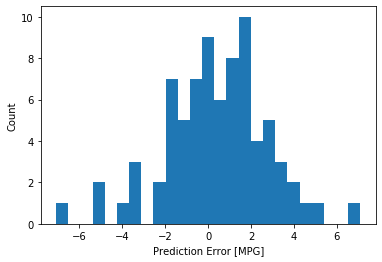

In [119]:
# Let's take a look at the error distribution.
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

# It's not quite gaussian, but we might expect that because the number of samples is very small.

## Conclusion
### This notebook introduced a few techniques to handle a regression problem.

### - Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
### - Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
### - When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
### - If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
### - Early stopping is a useful technique to prevent overfitting.
